# Telecom Customer Churn: Predictive Modeling

Reads the feature-engineered dataset from `data/03_featured/churn_featured.csv` and trains four classifiers:
- **Logistic Regression** — ImbPipeline + SMOTE + GridSearchCV (aggressive recall)
- **XGBoost** — scale_pos_weight + RandomizedSearchCV
- **LightGBM** — class_weight balanced + RandomizedSearchCV
- **Random Forest** — reduced GridSearchCV, no imbalance correction (conservative baseline)

In [ ]:
import os
import json
import time
import warnings
import glob
import logging
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import joblib

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
logging.getLogger('lightgbm').setLevel(logging.ERROR)

# Local src
from src.schemas import POST_WRANGLING_SCHEMA
from src.schemas import POST_FEATURE_ENGINEERING_SCHEMA
from src.schemas import MODEL_INPUT_SCHEMA
from src.feature_engineering import feature_engineering

model_dir = os.path.join('..', 'models')
training_times = {}

print('Done')

Done


In [2]:
data_path = os.path.join('..', 'data', '03_featured', 'churn_featured.csv')
df = pd.read_csv(data_path)

In [3]:
EXPECTED_COLUMNS = POST_FEATURE_ENGINEERING_SCHEMA["expected_columns"]
MIN_ROWS = POST_FEATURE_ENGINEERING_SCHEMA.get("min_rows", 0)

assert set(df.columns) == EXPECTED_COLUMNS, f"Column mismatch: expected {EXPECTED_COLUMNS}, got {set(df.columns)} — check data source."
assert len(df) >= MIN_ROWS, f"Row count {len(df)} is below minimum {MIN_ROWS} — check data source."
print(f"Schema OK: {len(df)} rows, {len(df.columns)} columns.")

Schema OK: 7032 rows, 21 columns.


## Data Preparation

Split into train/test, verify stratification preserves class balance, and define column-type-specific preprocessors.
Two preprocessor variants are used:
- `preprocessor_log` — for Logistic Regression: OHE with `drop='first'` to avoid dummy trap.
- `preprocessor_trees` — for tree-based models: OHE without drop (trees are invariant to collinearity).

In [4]:
X = df.drop(columns='churn')
y = df['churn'].map({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11, stratify=y
)

print("Train class distribution:")
print(y_train.value_counts(normalize=True).round(4).to_string())
print("\nTest class distribution:")
print(y_test.value_counts(normalize=True).round(4).to_string())

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumerical features ({len(num_cols)}): {num_cols}")
print(f"Categorical features ({len(cat_cols)}): {cat_cols}")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

preprocessor_log = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
])

preprocessor_trees = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
])

Train class distribution:
churn
0    0.7342
1    0.2658

Test class distribution:
churn
0    0.7342
1    0.2658

Numerical features (3): ['tenure', 'monthly_charges', 'contract_stability']
Categorical features (14): ['senior_citizen', 'partner', 'dependents', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'payment_method', 'high_risk_tenure']


## Logistic Regression
SMOTE applied inside the `ImbPipeline` per CV fold to prevent data leakage. Tuned over C and penalty via `GridSearchCV` with `roc_auc` scoring.

In [5]:
lr_pipeline = ImbPipeline([
    ('pre', preprocessor_log),
    ('smote', SMOTE(random_state=11)),
    ('classifier', LogisticRegression(max_iter=1000, solver='liblinear')),
])

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
}

gs_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=cv, scoring='roc_auc', n_jobs=-1)

t0 = time.perf_counter()
gs_lr.fit(X_train, y_train)
training_times['logistic_regression'] = round(time.perf_counter() - t0, 2)

best_lr = gs_lr.best_estimator_
print(f"Best params: {gs_lr.best_params_}")
print(f"CV ROC-AUC:  {gs_lr.best_score_:.4f}")
print(f"Wall time:   {training_times['logistic_regression']:.2f}s")

Best params: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
CV ROC-AUC:  0.8479
Wall time:   12.14s


c:\Users\zxrco\anaconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


              precision    recall  f1-score   support

    No Churn       0.90      0.74      0.82      1033
       Churn       0.52      0.78      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.77      1407



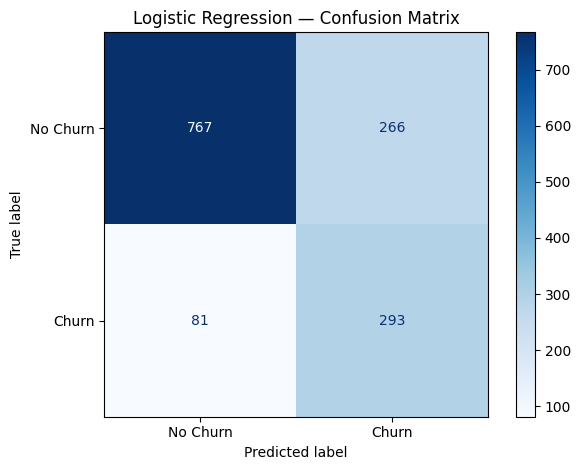

In [6]:
y_pred_lr = best_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, cmap='Blues', display_labels=['No Churn', 'Churn'])
plt.title("Logistic Regression — Confusion Matrix")
plt.tight_layout()
plt.show()

## XGBoost
`scale_pos_weight = neg/pos` handles class imbalance natively. `RandomizedSearchCV` (n_iter=40) samples from a wider distribution than an exhaustive grid at a fraction of the compute cost.

In [7]:
scale_pos_weight = float((y_train == 0).sum() / (y_train == 1).sum())

xgb_pipeline = Pipeline([
    ('pre', preprocessor_trees),
    ('classifier', XGBClassifier(
        random_state=11,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        verbosity=0,
    )),
])

param_dist_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
}

rs_xgb = RandomizedSearchCV(
    xgb_pipeline, param_dist_xgb,
    n_iter=40, cv=cv, scoring='roc_auc',
    n_jobs=-1, random_state=11,
)

t0 = time.perf_counter()
rs_xgb.fit(X_train, y_train)
training_times['xgboost'] = round(time.perf_counter() - t0, 2)

best_xgb = rs_xgb.best_estimator_
print(f"Best params: {rs_xgb.best_params_}")
print(f"CV ROC-AUC:  {rs_xgb.best_score_:.4f}")
print(f"Wall time:   {training_times['xgboost']:.2f}s")

c:\Users\zxrco\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
3 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zxrco\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\zxrco\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zxrco\anaconda3\envs\myenv\Lib\site-packages\sklearn\pipeline.py", lin

Best params: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8}
CV ROC-AUC:  0.8491
Wall time:   13.12s


              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.80      1033
       Churn       0.51      0.80      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.76      1407



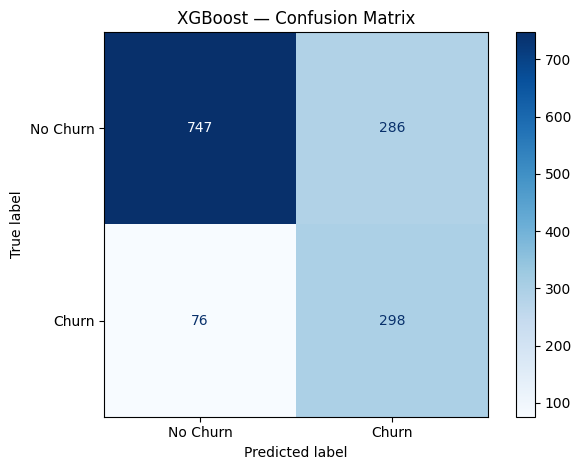

In [8]:
y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=['No Churn', 'Churn']))
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, cmap='Blues', display_labels=['No Churn', 'Churn'])
plt.title("XGBoost — Confusion Matrix")
plt.tight_layout()
plt.show()

## LightGBM
`class_weight='balanced'` handles imbalance. Exhaustive `GridSearchCV` over 108 combinations (leaves, depth, learning rate) — small enough for complete coverage.

In [9]:
lgbm_pipeline = Pipeline([
    ('pre', preprocessor_trees),
    ('classifier', LGBMClassifier(
        random_state=11,
        importance_type='gain',
        class_weight='balanced',
        boosting_type='gbdt',
        n_jobs=1,
        verbose=-1,
    )),
])

param_grid_lgbm = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 50, 63],
    'classifier__max_depth': [10, 15, 20, -1],
}

gs_lgbm = GridSearchCV(
    lgbm_pipeline, param_grid_lgbm,
    cv=cv, scoring='roc_auc',
    n_jobs=-1,
)

t0 = time.perf_counter()
gs_lgbm.fit(X_train, y_train)
training_times['lightgbm'] = round(time.perf_counter() - t0, 2)

best_lgbm = gs_lgbm.best_estimator_
print(f"Best params: {gs_lgbm.best_params_}")
print(f"CV ROC-AUC:  {gs_lgbm.best_score_:.4f}")
print(f"Wall time:   {training_times['lightgbm']:.2f}s")

Best params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'classifier__num_leaves': 31}
CV ROC-AUC:  0.8452
Wall time:   25.73s


              precision    recall  f1-score   support

    No Churn       0.90      0.73      0.81      1033
       Churn       0.51      0.77      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.75      1407



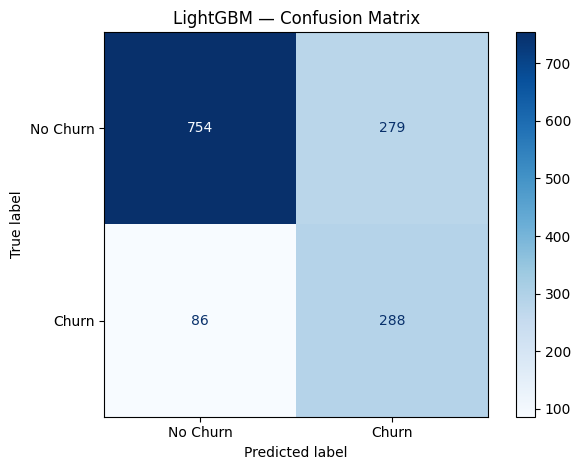

In [10]:
y_pred_lgbm = best_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_lgbm, target_names=['No Churn', 'Churn']))
ConfusionMatrixDisplay.from_estimator(best_lgbm, X_test, y_test, cmap='Blues', display_labels=['No Churn', 'Churn'])
plt.title("LightGBM — Confusion Matrix")
plt.tight_layout()
plt.show()

## Random Forest — Conservative Baseline
No imbalance correction applied intentionally: serves as the conservative baseline that minimises false positives (wasted outreach spend). Compare its precision vs. other models' recall to understand the precision-recall tradeoff.

In [11]:
rfc_pipeline = Pipeline([
    ('pre', preprocessor_trees),
    ('classifier', RandomForestClassifier(random_state=11, n_jobs=1)),
])

param_grid_rfc = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__max_features': ['sqrt', 'log2'],
}

gs_rfc = GridSearchCV(rfc_pipeline, param_grid_rfc, cv=cv, scoring='roc_auc', n_jobs=-1)

t0 = time.perf_counter()
gs_rfc.fit(X_train, y_train)
training_times['random_forest'] = round(time.perf_counter() - t0, 2)

best_rfc = gs_rfc.best_estimator_
print(f"Best params: {gs_rfc.best_params_}")
print(f"CV ROC-AUC:  {gs_rfc.best_score_:.4f}")
print(f"Wall time:   {training_times['random_forest']:.2f}s")

Best params: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
CV ROC-AUC:  0.8429
Wall time:   15.03s


              precision    recall  f1-score   support

    No Churn       0.83      0.91      0.87      1033
       Churn       0.67      0.47      0.55       374

    accuracy                           0.80      1407
   macro avg       0.75      0.69      0.71      1407
weighted avg       0.79      0.80      0.79      1407



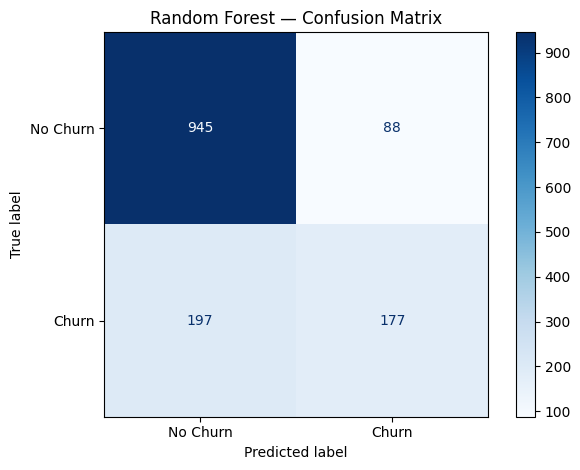

In [12]:
y_pred_rfc = best_rfc.predict(X_test)
print(classification_report(y_test, y_pred_rfc, target_names=['No Churn', 'Churn']))
ConfusionMatrixDisplay.from_estimator(best_rfc, X_test, y_test, cmap='Blues', display_labels=['No Churn', 'Churn'])
plt.title("Random Forest — Confusion Matrix")
plt.tight_layout()
plt.show()

## Model Comparison
Side-by-side metrics, ROC curves, and Precision-Recall curves for all four models.

In [13]:
models_dict = {
    "Logistic Regression": (best_lr, y_pred_lr),
    "XGBoost":             (best_xgb, y_pred_xgb),
    "LightGBM":            (best_lgbm, y_pred_lgbm),
    "Random Forest":       (best_rfc, y_pred_rfc),
}

model_strategy = {
    "Logistic Regression": "Aggressive recall (SMOTE) — catch most churners",
    "XGBoost":             "Balanced (scale_pos_weight) — strong overall",
    "LightGBM":            "Balanced (class_weight) — stable trade-off",
    "Random Forest":       "Conservative (no correction) — minimize false positives",
}

comparison_results = []
for model_name, (model, y_pred) in models_dict.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    comparison_results.append({
        "Model":       model_name,
        "Strategy":    model_strategy[model_name],
        "Accuracy":    accuracy_score(y_test, y_pred),
        "Precision":   precision_score(y_test, y_pred),
        "Recall":      recall_score(y_test, y_pred),
        "Specificity": tn / (tn + fp),
        "F1":          f1_score(y_test, y_pred),
        "ROC-AUC":     roc_auc_score(y_test, y_proba),
    })

comparison_df = (
    pd.DataFrame(comparison_results)
    .set_index("Model")
    .sort_values("ROC-AUC", ascending=False)
    .round(4)
)
comparison_df

,Strategy,Accuracy,Precision,Recall,Specificity,F1,ROC-AUC
Model,,,,,,,
Logistic Regression,Aggressive recall (SMOTE) — catch most churners,0.7534,0.5242,0.7834,0.7425,0.6281,0.8443
XGBoost,Balanced (scale_pos_weight) — strong overall,0.7427,0.5103,0.7968,0.7231,0.6221,0.8428
LightGBM,Balanced (class_weight) — stable trade-off,0.7406,0.5079,0.7701,0.7299,0.6121,0.8347
Random Forest,Conservative (no correction) — minimize false ...,0.7974,0.6679,0.4733,0.9148,0.5540,0.8330


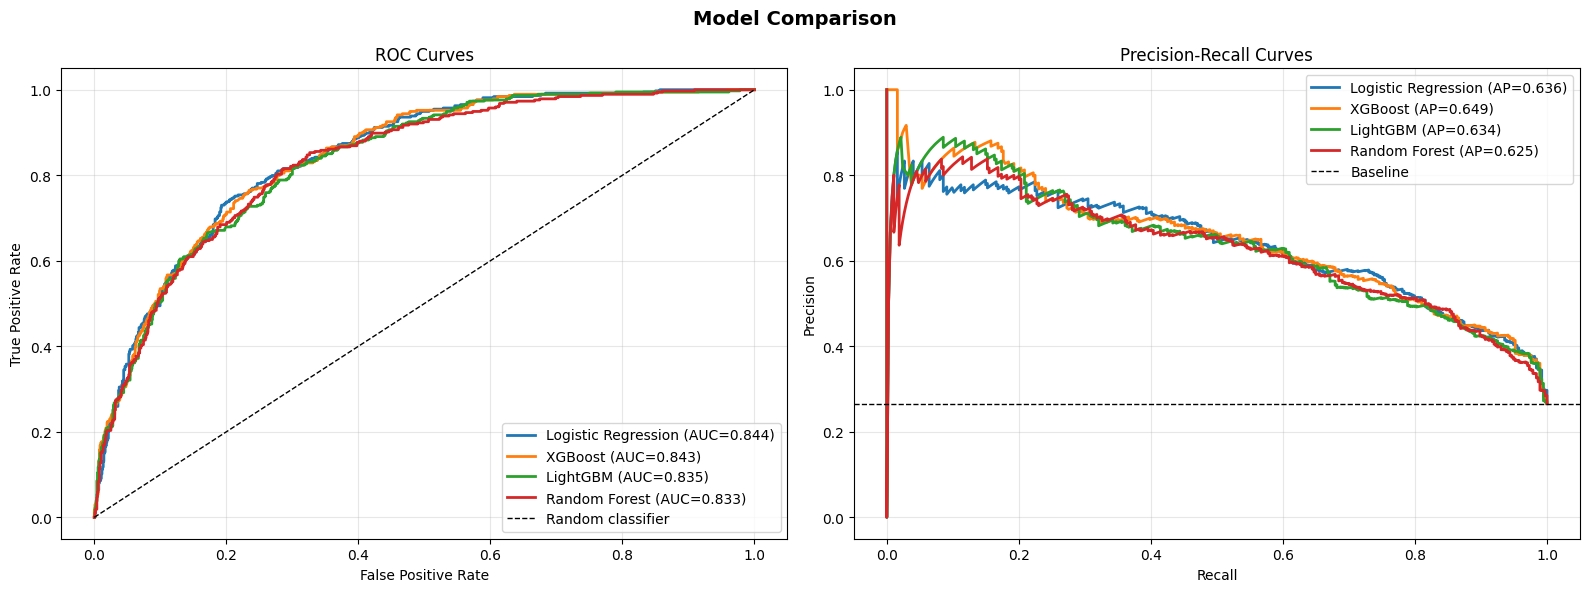

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for model_name, (model, _) in models_dict.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, linewidth=2, label=f"{model_name} (AUC={roc_auc:.3f})")

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

baseline_precision = y_test.mean()
for model_name, (model, _) in models_dict.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)
    axes[1].plot(rec, prec, linewidth=2, label=f"{model_name} (AP={pr_auc:.3f})")

axes[1].axhline(baseline_precision, color='k', linestyle='--', linewidth=1, label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.suptitle('Model Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Feature Importance
Extract feature importances from the best XGBoost model (gain-based) to validate EDA hypotheses and support stakeholder explanations.

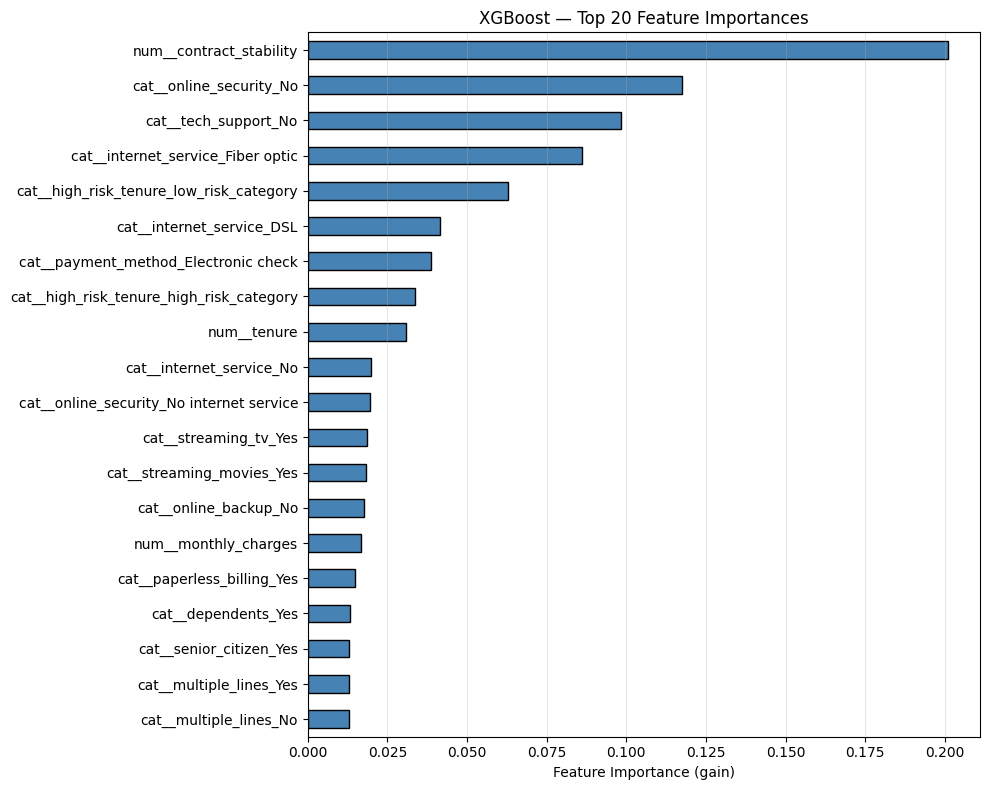

In [15]:
feature_names = best_xgb.named_steps['pre'].get_feature_names_out()

importances = best_xgb.named_steps['classifier'].feature_importances_

feat_imp = (
    pd.Series(importances, index=feature_names)
    .sort_values(ascending=True)
    .tail(20)  # top 20
)

fig, ax = plt.subplots(figsize=(10, 8))
feat_imp.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Feature Importance (gain)')
ax.set_title('XGBoost — Top 20 Feature Importances')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Save Best Models
Each model is persisted with `joblib` plus a JSON sidecar containing hyperparameters, test metrics, feature list, and timestamp — providing full reproducibility without re-running the grid search.

In [17]:
os.makedirs(model_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

best_search = {
    "logistic_regression": gs_lr,
    "xgboost":             rs_xgb,
    "lightgbm":            gs_lgbm,
    "random_forest":       gs_rfc,
}

fitted_models = {
    "logistic_regression": best_lr,
    "xgboost":             best_xgb,
    "lightgbm":            best_lgbm,
    "random_forest":       best_rfc,
}

preds = {
    "logistic_regression": y_pred_lr,
    "xgboost":             y_pred_xgb,
    "lightgbm":            y_pred_lgbm,
    "random_forest":       y_pred_rfc,
}

print("Saving models...")
for name, model in fitted_models.items():
    model_path = os.path.join(model_dir, f"{name}_{timestamp}.joblib")
    joblib.dump(model, model_path)

    y_pred_tmp = preds[name]
    y_proba_tmp = model.predict_proba(X_test)[:, 1]
    metadata = {
        "model_name":   name,
        "timestamp":    timestamp,
        "best_params":  {k: str(v) for k, v in best_search[name].best_params_.items()},
        "cv_roc_auc":   round(best_search[name].best_score_, 4),
        "test_metrics": {
            "accuracy":  round(accuracy_score(y_test, y_pred_tmp), 4),
            "precision": round(precision_score(y_test, y_pred_tmp), 4),
            "recall":    round(recall_score(y_test, y_pred_tmp), 4),
            "f1":        round(f1_score(y_test, y_pred_tmp), 4),
            "roc_auc":   round(roc_auc_score(y_test, y_proba_tmp), 4),
        },
        "training_time_seconds": training_times.get(name),
        "train_size":   len(X_train),
        "test_size":    len(X_test),
        "features":     list(X.columns),
    }
    meta_path = os.path.join(model_dir, f"{name}_{timestamp}_meta.json")
    with open(meta_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"  {name}: {model_path} ({training_times.get(name, '?')}s)")

print("Done.")

Saving models...
  logistic_regression: ..\models\logistic_regression_20260219_235331.joblib (12.14s)
  xgboost: ..\models\xgboost_20260219_235331.joblib (13.12s)
  lightgbm: ..\models\lightgbm_20260219_235331.joblib (25.73s)
  random_forest: ..\models\random_forest_20260219_235331.joblib (15.03s)
Done.


## Inference — Scoring New Customers

Shows how to load a saved model artifact and produce a churn probability for new input data.
The input must match the same feature columns as the training set (see `features` in the JSON sidecar).

In [18]:
model_pattern = os.path.join(model_dir, 'xgboost_*.joblib')
model_files = sorted(glob.glob(model_pattern))

if not model_files:
    print("No saved model found — run the Save Best Models cell first.")
else:
    loaded_model = joblib.load(model_files[-1])
    print(f"Loaded model: {model_files[-1]}")

    example_customer = pd.DataFrame([{
        "churn": "Yes",
        "contract": "Month-to-month",
        "dependents": "No",
        "device_protection": "No",
        "gender": "Female",
        "internet_service": "Fiber optic",
        "monthly_charges": 79.95,
        "multiple_lines": "No",
        "online_backup": "No",
        "online_security": "No",
        "paperless_billing": "Yes",
        "partner": "No",
        "payment_method": "Electronic check",
        "phone_service": "Yes",
        "senior_citizen": "No",
        "streaming_movies": "No",
        "streaming_tv": "No",
        "tech_support": "No",
        "tenure": 5,
        "total_charges": 250

    }])
    
    assert set(example_customer.columns) == POST_WRANGLING_SCHEMA["expected_columns"], \
        f"Column mismatch: expected {POST_WRANGLING_SCHEMA['expected_columns']}, got {set(example_customer.columns)}"
    print(f"Input schema OK: {len(example_customer)} rows, {len(example_customer.columns)} columns.")

    example_customer = feature_engineering(example_customer, drop_replaced=True)
    example_customer = example_customer.drop(columns=['churn'])

    assert set(example_customer.columns) == MODEL_INPUT_SCHEMA["expected_columns"], \
        f"Column mismatch: expected {MODEL_INPUT_SCHEMA['expected_columns']}, got {set(example_customer.columns)}"
    print(f"Model input schema OK: {len(example_customer)} rows, {len(example_customer.columns)} columns.")

    churn_proba = loaded_model.predict_proba(example_customer)[0, 1]
    churn_pred  = loaded_model.predict(example_customer)[0]

    print(f"\nChurn probability : {churn_proba:.1%}")
    print(f"Churn prediction  : {'Yes (Churn)' if churn_pred == 1 else 'No (Retain)'}")

Loaded model: ..\models\xgboost_20260219_235331.joblib
Input schema OK: 1 rows, 20 columns.
Model input schema OK: 1 rows, 20 columns.

Churn probability : 84.3%
Churn prediction  : Yes (Churn)


## Summary of Predictive Modeling

### Models Trained:

| Model | Imbalance Strategy | Search |
|---|---|---|
| Logistic Regression | SMOTE inside `ImbPipeline` | `GridSearchCV` |
| XGBoost | `scale_pos_weight = neg/pos` | `RandomizedSearchCV` (n_iter=40) |
| LightGBM | `class_weight='balanced'` | `GridSearchCV` |
| Random Forest | None — conservative baseline | `GridSearchCV` |

### Model Performance (test set, 80/20 split, 5-fold stratified CV):

| Model | Recall | F1 | ROC-AUC |
|---|:---:|:---:|:---:|
| Logistic Regression | 0.7834 | 0.6281 | 0.8443 |
| **XGBoost** | **0.7968** | **0.6221** | **0.8428** |
| LightGBM | 0.7701 | 0.6121 | 0.8347 |
| Random Forest | 0.4733 | 0.5540 | 0.8330 |

**Recommended model: XGBoost** — highest recall among tree-based models (0.80), top ROC-AUC (0.843), and simple imbalance handling. Random Forest accuracy (79.7%) is misleading — it misses 53% of churners. Top feature importances confirm EDA findings: `contract_stability`, `high_risk_new_monthly`, and `fiber_no_support`.

### Models Loading
All four models have been saved to `../models/` with JSON metadata sidecars.
